In [1]:
#from nilmtk.dataset_converters import convert_redd
from nilmtk.dataset_converters import convert_reddAlex
convert_reddAlex('data/REDD/low_freq2', 'data/data22.h5')
#convert_redd('data/REDD/dades', 'data/dades.h5')

Loading house 1... 1 2 3 4 5 6 7 8 9 
Loaded metadata
Done converting YAML metadata to HDF5!
Done converting REDD to HDF5!


In [2]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

In [3]:
rcParams['figure.figsize'] = (13, 6)

In [4]:
train = DataSet('data/data22.h5')
test = DataSet('data/data22.h5')
print(test.buildings[1].elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=60))

<generator object MeterGroup.load at 0x7f30755ea200>


In [5]:
building = 1

In [6]:
train.set_window(end="2011-04-29")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

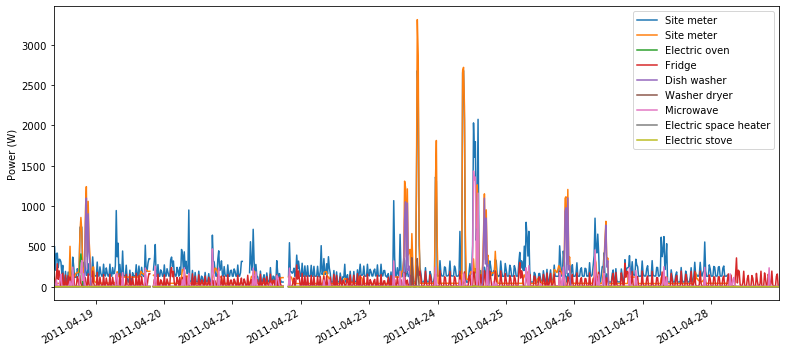

In [7]:
train_elec.plot()

In [8]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [9]:
top_5_train_elec = train_elec.submeters().select_top_k(k=1)
#top_5_train_elec = train_elec.submeters().select_using_appliances(type=['fridge', 'microwave'])

classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

7/7 ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])ce=1)])********************
CO
********************
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Done training!
Runtime = 0.6887013912200928 seconds.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Runtime = 0.9840660095214844 seconds.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [10]:
appliance_labels = [m.label() for m in gt.columns.values]

In [11]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels
#Create DataFrame
df = pd.DataFrame({predictions['CO'].head(25).to_string()})

#Convert the Columns to string
df[df.columns]=df[df.columns].astype(str)

#Create the list of column separator width 
SepWidth = [5,6,3,8]

#Temp dict
tempdf = {}
#Convert all the column to series
for i, eCol in enumerate(df):
    tempdf[i] = pd.Series(df[eCol]).str.pad(width=SepWidth[i])

#Final DataFrame
Fdf = pd.concat(tempdf, axis=1)
#print Fdf
#Export to csv
Fdf.to_csv("./testCO.txt", sep='\t', index=False, header=False, encoding='utf-8')




In [12]:
predictions['CO'].head(25)

,Fridge
2011-04-30 00:00:00-04:00,197.0
2011-04-30 00:02:00-04:00,197.0
2011-04-30 00:04:00-04:00,197.0
2011-04-30 00:06:00-04:00,197.0
2011-04-30 00:08:00-04:00,197.0
2011-04-30 00:10:00-04:00,197.0
2011-04-30 00:12:00-04:00,197.0
2011-04-30 00:14:00-04:00,197.0
2011-04-30 00:16:00-04:00,197.0
2011-04-30 00:18:00-04:00,197.0


In [13]:
predictions['FHMM'].head(25)

,Fridge
2011-04-30 00:00:00-04:00,168.0
2011-04-30 00:02:00-04:00,422.0
2011-04-30 00:04:00-04:00,422.0
2011-04-30 00:06:00-04:00,422.0
2011-04-30 00:08:00-04:00,422.0
2011-04-30 00:10:00-04:00,422.0
2011-04-30 00:12:00-04:00,422.0
2011-04-30 00:14:00-04:00,422.0
2011-04-30 00:16:00-04:00,422.0
2011-04-30 00:18:00-04:00,422.0


In [14]:
gt.head(25)

,Fridge
2011-04-30 00:00:00-04:00,6.000000
2011-04-30 00:02:00-04:00,6.000000
2011-04-30 00:04:00-04:00,6.000000
2011-04-30 00:06:00-04:00,6.100000
2011-04-30 00:08:00-04:00,6.612903
2011-04-30 00:10:00-04:00,6.656250
2011-04-30 00:12:00-04:00,6.843750
2011-04-30 00:14:00-04:00,6.806452
2011-04-30 00:16:00-04:00,6.843750
2011-04-30 00:18:00-04:00,6.812500


In [17]:
print(predictions['FHMM'])

                           Fridge
2011-04-30 00:00:00-04:00   168.0
2011-04-30 00:02:00-04:00   422.0
2011-04-30 00:04:00-04:00   422.0
2011-04-30 00:06:00-04:00   422.0
2011-04-30 00:08:00-04:00   422.0
...                           ...
2011-05-24 14:30:00-04:00   168.0
2011-05-24 14:32:00-04:00   168.0
2011-05-24 14:34:00-04:00   168.0
2011-05-24 15:54:00-04:00   168.0
2011-05-24 15:56:00-04:00   168.0

[6240 rows x 1 columns]
